# KNN

In [2]:
from preprocessing import *

In [3]:
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

In [4]:
df_data.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


## procesado 1

In [7]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [13]:
# Asi me ahorro copy pastear esta celda varias veces
def correr_todos_los_preprocesados(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [44]:
volver = ['volveria']
columnas = columnillas + volver

In [14]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = correr_todos_los_preprocesados(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2,1.0


In [15]:
df.shape

(801, 15)

## Entrenamiento

In [16]:
X = df.loc[:,columnillas]
y = df.loc[:,'volveria']

In [17]:
(X.shape, y.shape)

((801, 14), (801,))

In [18]:
X.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

In [41]:
params = {'n_neighbors': np.arange(3, 10),
          'weights': ['uniform','distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree'],
          'leaf_size': np.arange(15, 40),
          'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
         }

model_knn = KNeighborsClassifier()

In [20]:
rgscv = GridSearchCV(
    model_knn, params, scoring='roc_auc', cv=5, return_train_score=True
).fit(X_train, y_train)

In [21]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8464098249149508
Best params {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [22]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

test_rocs = []
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    knn = KNeighborsClassifier( 
                n_neighbors = rgscv.best_params_['n_neighbors'],
                weights = rgscv.best_params_['weights'],
                algorithm = rgscv.best_params_['algorithm'],
                leaf_size = rgscv.best_params_['leaf_size'],
                metric= rgscv.best_params_['metric']
                )
    knn.fit(X.iloc[train_index], y.iloc[train_index])
    test_roc = roc_auc_score(y.iloc[test_index], knn.predict(X.iloc[test_index]))
    print(f"Fold {fold_idx}: AUC ROC score is {test_roc:.4f}")
    test_rocs.append(test_roc)
print(f"Mean test AUC ROC is: {np.mean(test_rocs):.4f}")

Fold 0: AUC ROC score is 0.7277
Fold 1: AUC ROC score is 0.7704
Fold 2: AUC ROC score is 0.8051
Fold 3: AUC ROC score is 0.7976
Fold 4: AUC ROC score is 0.7920
Mean test AUC ROC is: 0.7785


### AUC ROC

In [23]:
roc = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
print(f"{roc:.4f}")

0.9758


### Accuracy

In [24]:
acc = accuracy_score(y_test, knn.predict(X_test))
print(f"{acc:.4f}")

0.9751


### Precision

In [25]:
precision_score(y_test, knn.predict(X_test))

1.0

### Recall

In [26]:
recall_score(y_test, knn.predict(X_test), pos_label=0)

1.0

### F1-Score

In [27]:
f1 = f1_score(y_test, knn.predict(X_test))
print(f"{f1:.4f}")

0.9650


## Matriz de confusión

/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


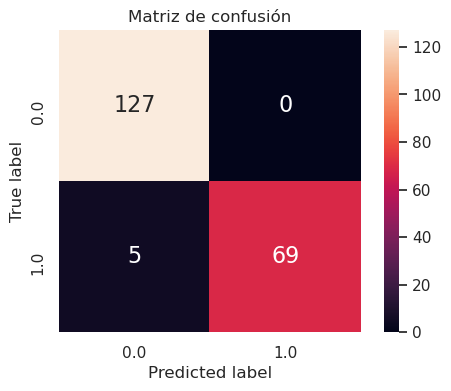

In [28]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusión")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, knn.predict(X_test))

## Test Holdout

In [29]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [30]:
df_h = correr_todos_los_preprocesados(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.450858,0.0,0.0,0.000000,1,0,0,0.0


In [31]:
y_pred = knn.predict(df_h)
y_pred

array([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0.])

In [32]:
y_pred = y_pred.astype(int)
y_pred

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0])

In [33]:
(y_pred.shape, df_h.shape)

((90,), (90, 14))

In [34]:
serie_predicha = pd.Series(y_pred, name='volveria') 
serie_predicha = serie_predicha.to_frame()
serie_predicha.head(15)

,volveria
0,0
1,0
2,0
3,0
4,0
5,1
6,1
7,0
8,1
9,0


In [38]:
df_predicho = holdout.join(serie_predicha, how='inner')

cols = ['id_usuario', 'volveria']
df_resultado = df_predicho[cols]
df_resultado.head(15)

,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,1
9,112,0


In [39]:
df_resultado.shape

(90, 2)

In [40]:
df_resultado.to_csv('prediccion/knn_resultado_final.csv')

## procesado 2

In [42]:
def segundo_set_de_preprocesados(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, False)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [50]:
seguidores = ['cant_acompañantes']
columnas_nuevas = set(columnas) - set(seguidores)
columnas_nuevas

{'amigos',
 'edad',
 'genero_mujer',
 'genero_nan',
 'id_usuario',
 'nombre_sede_fiumark_palermo',
 'nombre_sede_fiumark_quilmes',
 'nombre_sede_nan',
 'parientes',
 'precio_ticket',
 'tipo_de_sala_4d',
 'tipo_de_sala_nan',
 'tipo_de_sala_normal',
 'volveria'}

In [51]:
df_2 = segundo_set_de_preprocesados(dataset, columnas_nuevas)
df_2.head()

,genero_mujer,genero_nan,tipo_de_sala_normal,volveria,tipo_de_sala_nan,edad,nombre_sede_nan,amigos,precio_ticket,nombre_sede_fiumark_palermo,id_usuario,tipo_de_sala_4d,nombre_sede_fiumark_quilmes,parientes
0,0,0,0,0.0,0,0.880653,0,0.000,0.000000,0,0.130337,1,1,0.000000
1,1,0,0,0.0,0,0.396985,0,0.125,0.020408,0,0.738202,1,1,0.166667
2,0,0,1,0.0,0,0.368090,0,0.000,0.040816,0,0.891011,0,0,0.000000
3,0,0,0,0.0,0,0.368090,0,0.000,0.000000,1,0.510112,1,0,0.000000
4,1,0,0,1.0,0,0.007538,0,0.125,0.020408,1,0.193258,1,0,0.166667


In [56]:
df_2.shape

(801, 14)

In [57]:
columnas_2 = ['genero_mujer', 'genero_nan', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'tipo_de_sala_4d', 
               'edad', 'nombre_sede_nan', 'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes',
              'amigos', 'precio_ticket', 'precio_ticket', 'id_usuario']

In [58]:
X_2 = df_2.loc[:,columnas_2]
y_2 = df_2.loc[:,'volveria']

In [59]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=117)

In [60]:
modelo_2 = GridSearchCV(
    model_knn, params, scoring='roc_auc', cv=5, return_train_score=True
).fit(X_train_2, y_train_2)

In [61]:
print(f"Best score: {modelo_2.best_score_}")
print(f"Best params {modelo_2.best_params_}")

Best score: 0.8449964826129082
Best params {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [69]:
test_rocs = []
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_2, y_2)):
    knn_2 = KNeighborsClassifier( 
                n_neighbors = modelo_2.best_params_['n_neighbors'],
                weights = modelo_2.best_params_['weights'],
                algorithm = modelo_2.best_params_['algorithm'],
                leaf_size = modelo_2.best_params_['leaf_size'],
                metric= modelo_2.best_params_['metric']
                )
    knn_2.fit(X_2.iloc[train_index], y_2.iloc[train_index])
    test_roc = roc_auc_score(y_2.iloc[test_index], knn_2.predict(X_2.iloc[test_index]))
    print(f"Fold {fold_idx}: AUC ROC score is {test_roc:.4f}")
    test_rocs.append(test_roc)
print(f"Mean test AUC ROC is: {np.mean(test_rocs):.4f}")

Fold 0: AUC ROC score is 0.7035
Fold 1: AUC ROC score is 0.7887
Fold 2: AUC ROC score is 0.7887
Fold 3: AUC ROC score is 0.7938
Fold 4: AUC ROC score is 0.7737
Mean test AUC ROC is: 0.7697


### Metricas

In [73]:
roc = roc_auc_score(y_test_2, knn_2.predict_proba(X_test_2)[:,1])
precision = precision_score(y_test_2, knn_2.predict(X_test_2))
recall = recall_score(y_test_2, knn_2.predict(X_test_2), pos_label=0)
f1 = f1_score(y_test_2, knn_2.predict(X_test_2))
acc = accuracy_score(y_test_2, knn_2.predict(X_test_2))

print('accuracy: ' f"{acc:.4f}")
print('auc roc: ' f"{roc:.4f}")
print('precision: ' f"{precision:.4f}")
print('recall: ' f"{recall:.4f}")
print('F1-Score: ' f"{f1:.4f}")

accuracy: 0.9701
auc roc: 0.9819
precision: 0.9857
recall: 0.9921
F1-Score: 0.9583


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


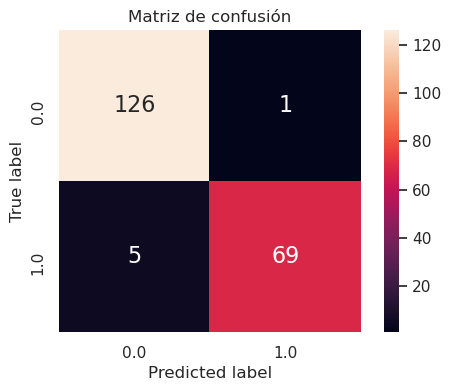

In [74]:
plot_confusion_matrix(y_test_2, knn_2.predict(X_test_2))

### 2do holdout

In [80]:
df_h_2 = segundo_set_de_preprocesados(holdout, columnas_nuevas)

df_h_2.head()

,genero_mujer,genero_nan,tipo_de_sala_normal,volveria,tipo_de_sala_nan,edad,nombre_sede_nan,amigos,precio_ticket,nombre_sede_fiumark_palermo,id_usuario,tipo_de_sala_4d,nombre_sede_fiumark_quilmes,parientes
0,1,0,0,NaN,0,0.344774,0,0.0,0.000000,1,0.751756,1,0,0.0
1,1,0,0,NaN,0,0.063963,0,0.5,0.061224,1,0.264637,1,0,0.4
2,0,0,1,NaN,0,0.609984,0,0.0,0.040816,0,0.026932,0,0,0.0
3,0,0,0,NaN,0,0.407176,0,0.0,0.040816,1,0.637002,0,0,0.0
4,0,0,0,NaN,0,0.450858,0,0.0,0.000000,1,0.471897,1,0,0.0


In [81]:
df_h_2 = df_h_2.drop(['volveria'], axis=1)
y_pred_2 = knn_2.predict(df_h_2)
y_pred_2 = y_pred_2.astype(int)
y_pred_2

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0])

In [82]:
serie_predicha_2 = pd.Series(y_pred_2, name='volveria') 
serie_predicha_2 = serie_predicha_2.to_frame()
serie_predicha_2.head(15)

,volveria
0,1
1,1
2,0
3,0
4,0
5,1
6,1
7,0
8,0
9,1


In [83]:
df_predicho = holdout.join(serie_predicha_2, how='inner')

cols = ['id_usuario', 'volveria']
df_resultado = df_predicho[cols]
df_resultado.head(15)

,id_usuario,volveria
0,650,1
1,234,1
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [ ]:
df_resultado.to_csv('prediccion/knn_2do_prepoc_resultado_final.csv')